In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
%matplotlib inline


### **Data Preparation**

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())
test_dataset = MNIST(root='data/', train=False, transform=ToTensor())

In [ ]:
len(dataset)

60000

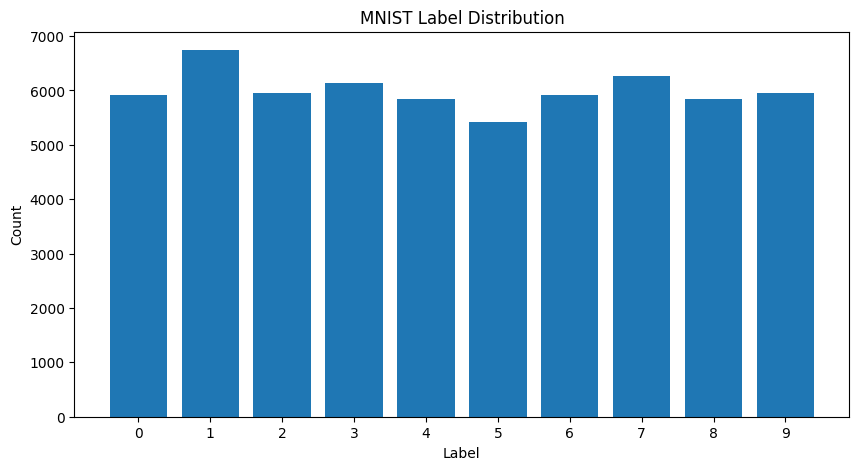

In [ ]:
labels = dataset.targets
label_counts = torch.bincount(labels)
plt.figure(figsize=(10,5))
plt.bar(range(10), label_counts)
plt.xticks(range(10), [str(i) for i in range(10)])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("MNIST Label Distribution")
plt.show()

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


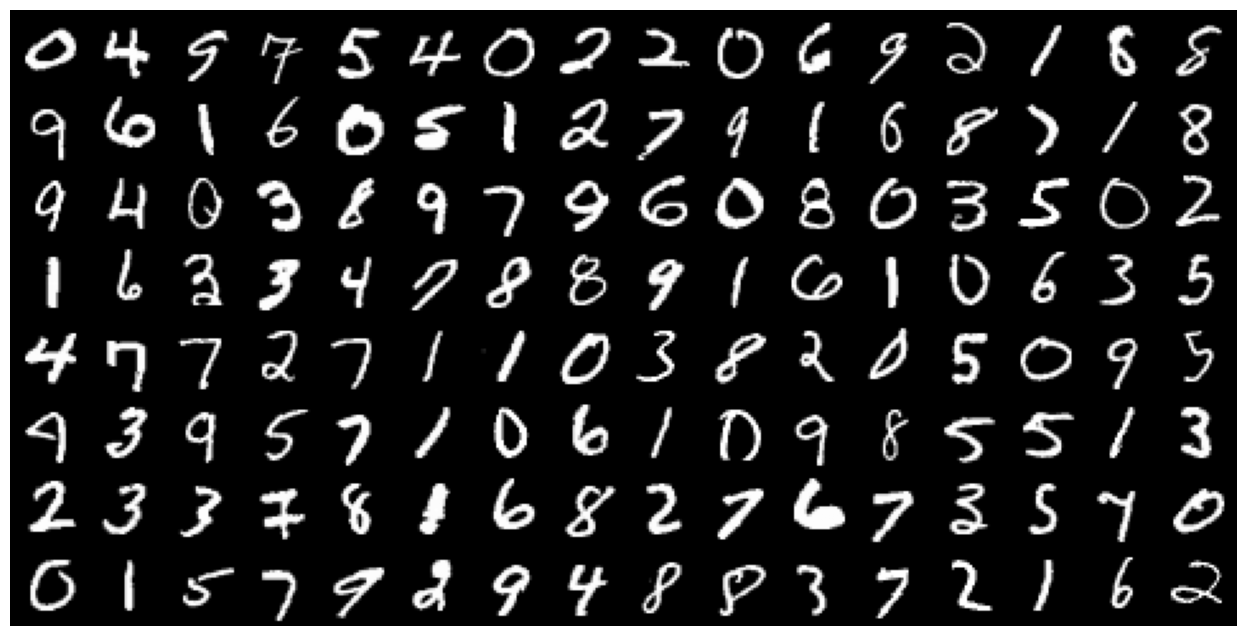

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

### **FeedForward Convolutional Neural Netowork**

# **Model Summary**
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 32, 28, 28]             832
            Conv2d-2           [-1, 64, 14, 14]          51,264
            Linear-3                 [-1, 1024]       3,212,288
            Linear-4                   [-1, 10]          10,250
================================================================
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 12.49
Estimated Total Size (MB): 12.79
----------------------------------------------------------------

```



In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

### **Move Data into a GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

### **Model Training**

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = MnistModel()
to_device(model, device)

MnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
            Conv2d-2           [-1, 64, 14, 14]          51,264
            Linear-3                 [-1, 1024]       3,212,288
            Linear-4                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.29
Params size (MB): 12.49
Estimated Total Size (MB): 12.79
----------------------------------------------------------------


<ipython-input-21-2ff00cc00e86>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
history = [evaluate(model, val_loader)]
history

<ipython-input-21-2ff00cc00e86>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[{'val_loss': 2.3074562549591064, 'val_acc': 0.09990234673023224}]

In [ ]:
history += fit(30, 0.5, model, train_loader, val_loader)

<ipython-input-21-2ff00cc00e86>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch [0], val_loss: 0.1844, val_acc: 0.9413
Epoch [1], val_loss: 0.0816, val_acc: 0.9763
Epoch [2], val_loss: 0.0629, val_acc: 0.9825
Epoch [3], val_loss: 0.0709, val_acc: 0.9792
Epoch [4], val_loss: 0.0557, val_acc: 0.9847
Epoch [5], val_loss: 0.0608, val_acc: 0.9818
Epoch [6], val_loss: 0.0497, val_acc: 0.9868
Epoch [7], val_loss: 0.0417, val_acc: 0.9883
Epoch [8], val_loss: 0.0424, val_acc: 0.9884
Epoch [9], val_loss: 0.0562, val_acc: 0.9815
Epoch [10], val_loss: 0.0403, val_acc: 0.9898
Epoch [11], val_loss: 0.0421, val_acc: 0.9894
Epoch [12], val_loss: 0.0522, val_acc: 0.9876
Epoch [13], val_loss: 0.0461, val_acc: 0.9879
Epoch [14], val_loss: 0.0448, val_acc: 0.9896
Epoch [15], val_loss: 0.0392, val_acc: 0.9898
Epoch [16], val_loss: 0.0374, val_acc: 0.9902
Epoch [17], val_loss: 0.0432, val_acc: 0.9900
Epoch [18], val_loss: 0.0432, val_acc: 0.9904
Epoch [19], val_loss: 0.0430, val_acc: 0.9887
Epoch [20], val_loss: 0.0536, val_acc: 0.9897
Epoch [21], val_loss: 0.0735, val_acc: 0.984

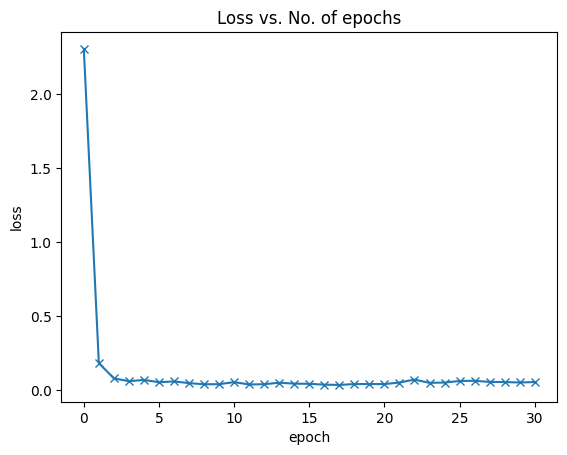

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

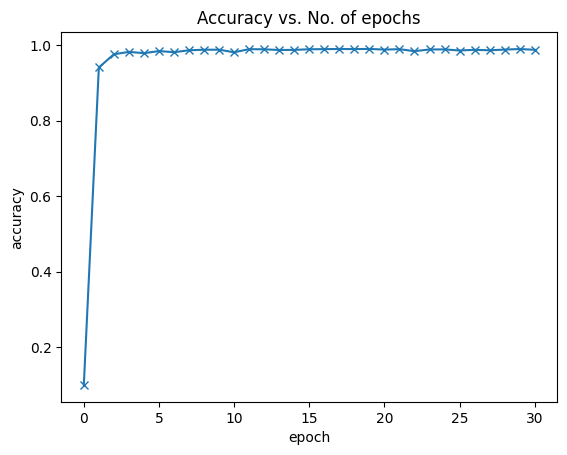

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### **Prediction Generation**

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 0 - zero , Predicted: 0 - zero


<ipython-input-21-2ff00cc00e86>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


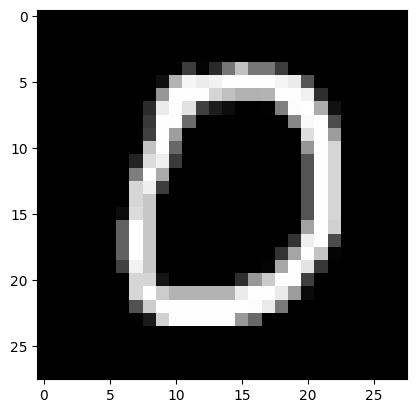

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

In [ ]:
evaluate(model, test_loader)

<ipython-input-21-2ff00cc00e86>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


{'val_loss': 0.050552260130643845, 'val_acc': 0.989062488079071}

In [ ]:
saved_weights_fname='MNIST_HWDR_2D-feedforward.pth'

In [ ]:
torch.save(model.state_dict(), saved_weights_fname)